1. Load and Inspect the Data

In [5]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('StockPriceDataset.csv')  # adjust file name if needed

# Preview data
print(df.head())
print(df.columns)
print(df.info())


         Date       Open       High        Low      Close  Adj Close  \
0  2014-01-02  19.845715  19.893929  19.715000  19.754642  17.273226   
1  2014-01-03  19.745001  19.775000  19.301071  19.320715  16.893808   
2  2014-01-06  19.194643  19.528570  19.057142  19.426071  16.985926   
3  2014-01-07  19.440001  19.498571  19.211430  19.287144  16.864458   
4  2014-01-08  19.243214  19.484285  19.238930  19.409286  16.971254   

      Volume Ticker  
0  234684800   AAPL  
1  392467600   AAPL  
2  412610800   AAPL  
3  317209200   AAPL  
4  258529600   AAPL  
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Ticker'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25160 entries, 0 to 25159
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       25160 non-null  object 
 1   Open       25160 non-null  float64
 2   High       25160 non-null  float64
 3   Low        2

2. Preprocess the Data

2.1.  Clean and Prepare

In [6]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date
df = df.sort_values('Date')

# Convert Volume to numeric (it’s currently a string)
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

# Drop any rows with missing values
df = df.dropna()


2.2. Filter a Single Stock

In [7]:
# Choose one stock to work with (check available tickers)
print(df['Ticker'].unique())  # Show available tickers

# Filter for AAPL stock
stock_df = df[df['Ticker'] == 'AAPL'].copy()


['AAPL' 'PG' 'AMZN' 'JNJ' 'GS' 'XOM' 'JPM' 'CAT' 'MSFT' 'KO']


3. Create Features and Target Column

In [8]:
# Create 'Target' column (next day's close)
stock_df['Target'] = stock_df['Close'].shift(-1)

# Drop the last row (has NaN in 'Target')
stock_df = stock_df.dropna(subset=['Target'])

# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Target'

X = stock_df[features]
y = stock_df[target]


4. Train/Test Split

In [9]:
from sklearn.model_selection import train_test_split

# Split data — no shuffle since it's time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


5. Train a Linear Regression Model

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 8.475346609803417


6. Plot Actual vs Predicted Prices

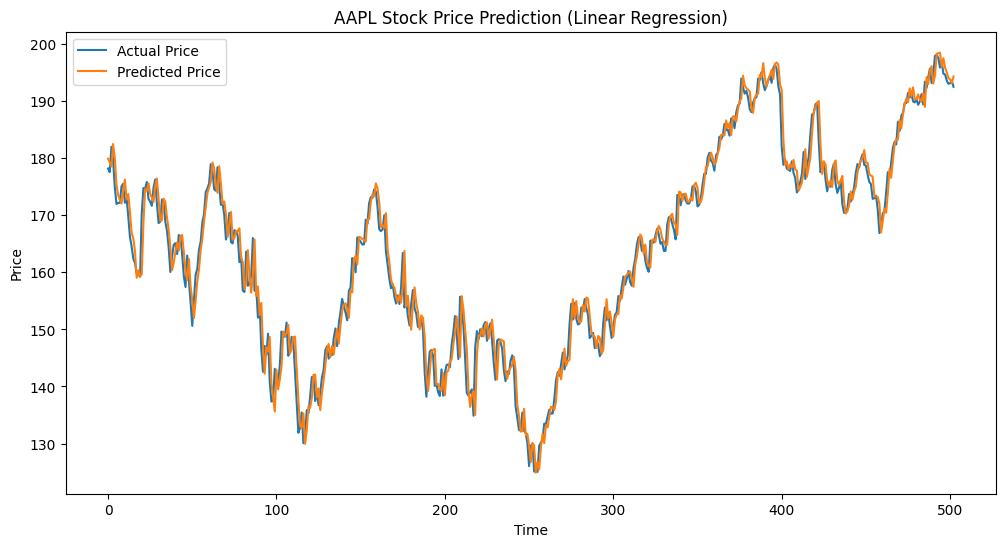

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('AAPL Stock Price Prediction (Linear Regression)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


7. Scale Data

LSTMs need scaled data. We’ll use MinMaxScaler on features and target.

In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

# Scale features (Open, High, Low, Close, Volume)
scaled_features = scaler.fit_transform(stock_df[features])

# Scale target separately (reshape required)
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(stock_df[target].values.reshape(-1, 1))


8. Create Time Sequences (Look-back window)

We create sequences of past n days to predict the next day.

In [13]:
def create_sequences(features, target, time_steps=10):
    Xs, ys = [], []
    for i in range(len(features) - time_steps):
        Xs.append(features[i:(i + time_steps)])
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_lstm, y_lstm = create_sequences(scaled_features, scaled_target, time_steps)


9. Train/Test Split

In [14]:
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]


In [15]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R2 Score:", r2_score(y_test, y_pred_rf))


MSE: 36.8265524835773
MAE: 4.379045563047498
R2 Score: 0.8821009292320592


10. LSTM training code

Epoch 1/20


c:\Users\tashf\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0200 - val_loss: 0.0022
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5962e-04 - val_loss: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2938e-04 - val_loss: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1882e-04 - val_loss: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0580e-04 - val_loss: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0212e-04 - val_loss: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9652e-04 - val_loss: 0.0011
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9174e-04 - val_loss: 0.0010
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9066e-04 - val_loss: 0.0012
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9124e-04 - val_loss: 0.0011
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9638e-04 - val_loss: 0.0010
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

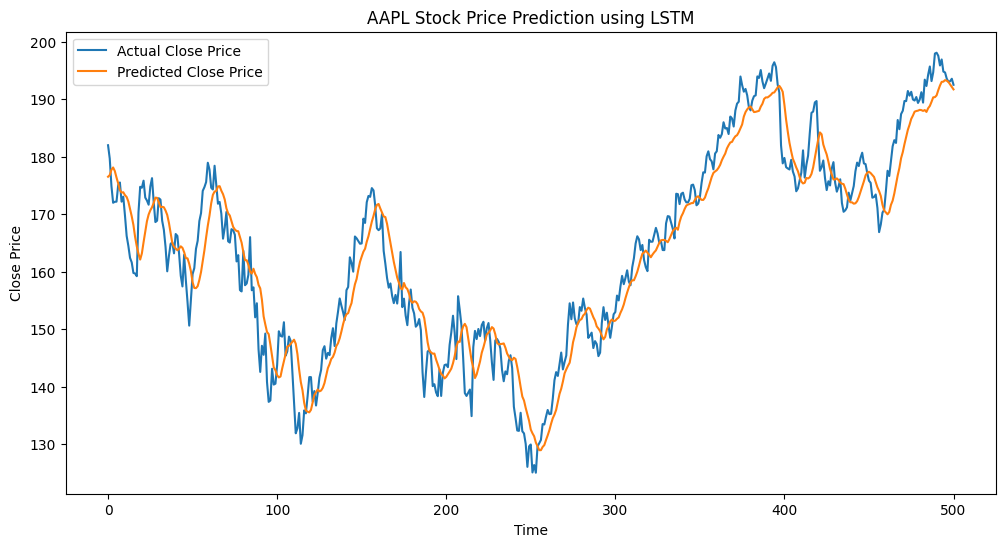

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- Step 1: Load and preprocess data ---
df = pd.read_csv('StockPriceDataset.csv')  # your file name
df['Date'] = pd.to_datetime(df['Date'])

# Filter for one stock (AAPL)
stock_df = df[df['Ticker'] == 'AAPL'].copy()

# Sort by date
stock_df = stock_df.sort_values('Date')

# Create Target column: next day Close price
stock_df['Target'] = stock_df['Close'].shift(-1)
stock_df.dropna(subset=['Target'], inplace=True)

# Features and target columns
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Target'

# --- Step 2: Scale features and target ---
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(stock_df[features])

target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(stock_df[target].values.reshape(-1,1))

# --- Step 3: Create sequences for LSTM ---
def create_sequences(features, target, time_steps=10):
    Xs, ys = [], []
    for i in range(len(features) - time_steps):
        Xs.append(features[i:(i + time_steps)])
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_lstm, y_lstm = create_sequences(scaled_features, scaled_target, time_steps)

# --- Step 4: Train/Test split ---
split = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

# --- Step 5: Define and train LSTM model ---
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# --- Step 6: Predict and evaluate ---
y_pred = model_lstm.predict(X_test)

# Inverse scale predictions and true values
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test)

print("LSTM Mean Squared Error:", mean_squared_error(y_test_inv, y_pred_inv))
print("LSTM Mean Absolute Error:", mean_absolute_error(y_test_inv, y_pred_inv))
print("LSTM R2 Score:", r2_score(y_test_inv, y_pred_inv))

# --- Step 7: Plot actual vs predicted ---
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Close Price')
plt.plot(y_pred_inv, label='Predicted Close Price')
plt.title('AAPL Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


11. Sanity check + light preprocessing

In [23]:
# --- CELL 1: Sanity check + light preprocessing ---

import numpy as np
import pandas as pd

# If you haven't defined stock_df yet, do it now (change the ticker if needed)
if "stock_df" not in locals():
    assert "df" in locals(), "Expected a dataframe named df. Please load your CSV into df first."
    TICKER = "AAPL"  # change if needed
    assert "Ticker" in df.columns, "Expected a 'Ticker' column in df to filter by ticker."
    stock_df = df[df["Ticker"] == TICKER].copy()

# Basic clean-up
# Ensure Date is datetime and sorted
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df = stock_df.sort_values("Date").reset_index(drop=True)

# Sometimes Volume comes as string with commas — make it numeric
if stock_df["Volume"].dtype == "object":
    stock_df["Volume"] = (
        stock_df["Volume"].astype(str).str.replace(",", "", regex=False).astype(float)
    )

# Keep only the columns we need
needed = ["Date", "Open", "High", "Low", "Close", "Volume"]
missing = [c for c in needed if c not in stock_df.columns]
if missing:
    raise ValueError(f"Missing columns in stock_df: {missing}")

stock_df = stock_df[needed].dropna()

print(stock_df.head(), "\n", stock_df.tail())
print("Rows:", len(stock_df))


        Date       Open       High        Low      Close     Volume
0 2014-01-02  19.845715  19.893929  19.715000  19.754642  234684800
1 2014-01-03  19.745001  19.775000  19.301071  19.320715  392467600
2 2014-01-06  19.194643  19.528570  19.057142  19.426071  412610800
3 2014-01-07  19.440001  19.498571  19.211430  19.287144  317209200
4 2014-01-08  19.243214  19.484285  19.238930  19.409286  258529600 
            Date        Open        High         Low       Close    Volume
2510 2023-12-21  196.100006  197.080002  193.500000  194.679993  46482500
2511 2023-12-22  195.179993  195.410004  192.970001  193.600006  37122800
2512 2023-12-26  193.610001  193.889999  192.830002  193.050003  28919300
2513 2023-12-27  192.490005  193.500000  191.089996  193.149994  48087700
2514 2023-12-28  194.139999  194.660004  193.169998  193.580002  34049900
Rows: 2515


12. Create a future target (predict next day Close), split train/test by time

In [ ]:

# Predict "next day's Close"
stock_df["Close_t+1"] = stock_df["Close"].shift(-1)
stock_df = stock_df.dropna(subset=["Close_t+1"]).reset_index(drop=True)

# Features and target
FEATURES = ["Open", "High", "Low", "Close", "Volume"]
TARGET = "Close_t+1"

X = stock_df[FEATURES].values
y = stock_df[[TARGET]].values  # keep 2D for scalers later
dates = stock_df["Date"].values

# 80/20 time split (no shuffling for time series)
split_idx = int(len(stock_df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_train, dates_test = dates[:split_idx], dates[split_idx:]

print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)


Train size: (2011, 5) (2011, 1)
Test size: (503, 5) (503, 1)


13. Baseline Model — Linear Regression (predict next-day Close)

In [25]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test).reshape(-1)
y_true = y_test.reshape(-1)

mae_lr = mean_absolute_error(y_true, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_true, y_pred_lr))
r2_lr = r2_score(y_true, y_pred_lr)

print(f"[Linear Regression] MAE: {mae_lr:.4f} | RMSE: {rmse_lr:.4f} | R²: {r2_lr:.4f}")


[Linear Regression] MAE: 2.2390 | RMSE: 2.9108 | R²: 0.9728


14. Actual vs Predicted (Linear Regression)

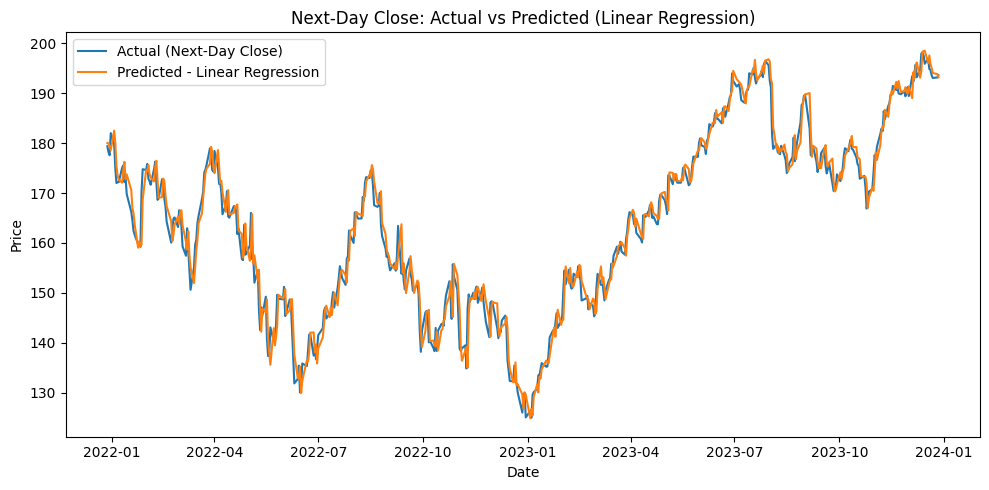

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(dates_test, y_true, label="Actual (Next-Day Close)")
plt.plot(dates_test, y_pred_lr, label="Predicted - Linear Regression")
plt.title("Next-Day Close: Actual vs Predicted (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


15. Prepare data for LSTM (scaling + sequences)

In [27]:

from sklearn.preprocessing import MinMaxScaler

# Scale features on TRAIN ONLY to avoid leakage
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled  = scaler_y.transform(y_test)

def make_sequences(X_arr, y_arr, lookback=60):
    """
    Create sequences of length `lookback` to predict the next y.
    Returns X_seq of shape (samples, lookback, features) and y_seq (samples, 1).
    """
    X_seq, y_seq = [], []
    for i in range(lookback, len(X_arr)):
        X_seq.append(X_arr[i - lookback:i, :])
        y_seq.append(y_arr[i, :])  # predict next day's y
    return np.array(X_seq), np.array(y_seq)

LOOKBACK = 60  # can try 30/60/90

X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_scaled, LOOKBACK)
X_test_seq,  y_test_seq  = make_sequences(X_test_scaled,  y_test_scaled,  LOOKBACK)

# Align test dates to the sequence cutoff
dates_test_seq = dates_test[LOOKBACK:]

print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("X_test_seq :", X_test_seq.shape,  "y_test_seq :", y_test_seq.shape)


X_train_seq: (1951, 60, 5) y_train_seq: (1951, 1)
X_test_seq : (443, 60, 5) y_test_seq : (443, 1)


16. LSTM model: build, train, and evaluate

In [28]:
# If TensorFlow isn't installed, uncomment the next line:
# !pip install tensorflow -q

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Reproducibility (best-effort)
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# Predict on test sequences
y_pred_seq_scaled = model.predict(X_test_seq).reshape(-1, 1)

# Inverse-scale predictions and ground truth to original price scale
y_pred_lstm = scaler_y.inverse_transform(y_pred_seq_scaled).reshape(-1)
y_true_lstm = scaler_y.inverse_transform(y_test_seq).reshape(-1)

# Metrics
mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm))
r2_lstm = r2_score(y_true_lstm, y_pred_lstm)

print(f"[LSTM] MAE: {mae_lstm:.4f} | RMSE: {rmse_lstm:.4f} | R²: {r2_lstm:.4f}")


Epoch 1/100


c:\Users\tashf\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.1872e-04 - val_loss: 0.0032
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.0825e-04 - val_loss: 0.0045
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.5677e-04 - val_loss: 0.0019
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.7670e-04 - val_loss: 0.0022
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.9369e-04 - val_loss: 0.0027
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.0234e-04 - val_loss: 0.0015
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.5012e-04 - val_loss: 0.0016
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.3729e-04 - val_loss: 0.0014
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.4228e-04 - val_loss: 0.0013
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.7454e-04 - val_loss: 0.0016
Epoch 12/100
49/49 ━━━━━

17. Plot: Actual vs Predicted (LSTM)

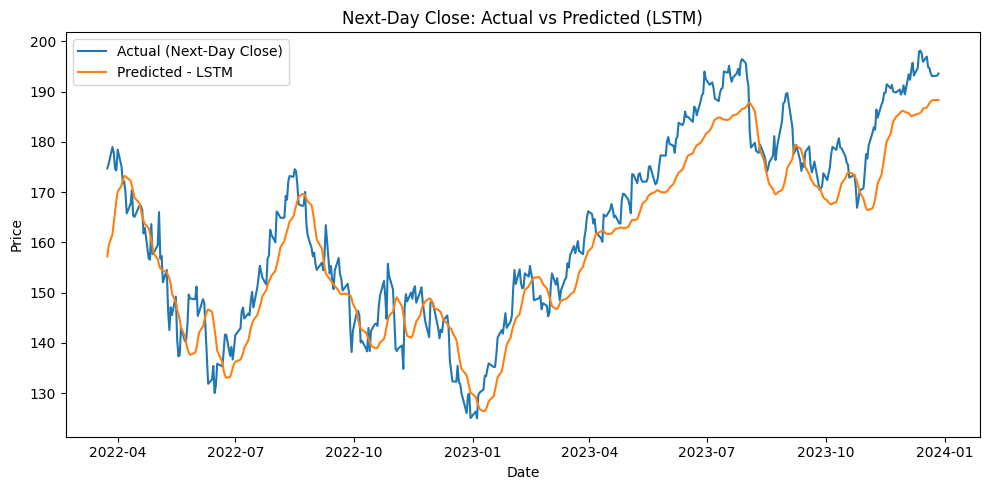

In [29]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(dates_test_seq, y_true_lstm, label="Actual (Next-Day Close)")
plt.plot(dates_test_seq, y_pred_lstm, label="Predicted - LSTM")
plt.title("Next-Day Close: Actual vs Predicted (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


18. Compare models side-by-side (table + quick note)

In [30]:
summary = pd.DataFrame(
    {
        "Model": ["Linear Regression", "LSTM"],
        "MAE":   [mae_lr, mae_lstm],
        "RMSE":  [rmse_lr, rmse_lstm],
        "R2":    [r2_lr, r2_lstm],
    }
)
summary


,Model,MAE,RMSE,R2
0,Linear Regression,2.239036,2.910814,0.972773
1,LSTM,5.799234,6.851211,0.863523


19. simple naïve baseline for context

In [32]:
# For the test set (non-sequence), y_true is already next-day close.
# Naïve: predict y_pred_naive[t] = today's Close of the same test day.
# That means use X_test[:, 3] (the "Close" feature) as prediction.
# NOTE: Because our target is next-day close, this is a surprisingly strong baseline.

close_today_test = X_test[:, FEATURES.index("Close")]
y_pred_naive = close_today_test  # predict next day's close = today's close

mae_naive = mean_absolute_error(y_true, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred_naive))
r2_naive = r2_score(y_true, y_pred_naive)

print(f"[Naïve (next= today close)] MAE: {mae_naive:.4f} | RMSE: {rmse_naive:.4f} | R²: {r2_naive:.4f}")

# Add to summary
summary = pd.concat([summary, pd.DataFrame({"Model":["Naïve (Close_t = Close_{t-1})"], "MAE":[mae_naive], "RMSE":[rmse_naive], "R2":[r2_naive]})], ignore_index=True)
summary


[Naïve (next= today close)] MAE: 2.1551 | RMSE: 2.8501 | R²: 0.9739


,Model,MAE,RMSE,R2
0,Linear Regression,2.239036,2.910814,0.972773
1,LSTM,5.799234,6.851211,0.863523
2,Naïve (Close_t = Close_{t-1}),2.155129,2.850125,0.973897
3,Naïve (Close_t = Close_{t-1}),2.155129,2.850125,0.973897


20. Scaling + sequence preparation

In [34]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale features and target (fit on train only)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

# FIX: y_train and y_test are already numpy arrays
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test.reshape(-1,1))

def make_sequences(X, y, lookback=60):
    """
    Create sequences of length `lookback` for LSTM.
    """
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

LOOKBACK = 60
X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_scaled, LOOKBACK)
X_test_seq, y_test_seq   = make_sequences(X_test_scaled,  y_test_scaled,  LOOKBACK)

print("Train shape:", X_train_seq.shape, y_train_seq.shape)
print("Test shape:", X_test_seq.shape, y_test_seq.shape)


Train shape: (1951, 60, 5) (1951, 1)
Test shape: (443, 60, 5) (443, 1)


21. Build & train LSTM

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/50


c:\Users\tashf\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.7607e-04 - val_loss: 0.0013
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.1362e-04 - val_loss: 0.0011
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.9110e-04 - val_loss: 0.0014
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.7312e-04 - val_loss: 0.0011
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.0456e-04 - val_loss: 0.0019
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.5888e-04 - val_loss: 0.0012
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.9554e-04 - val_loss: 0.0011
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.0953e-04 - val_loss: 0.0010
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.7961e-04 - val_loss: 0.0010
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.7265e-04 - val_loss: 0.0011
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━

22. Evaluate & plot predictions

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
[LSTM] MAE: 4.2464 | RMSE: 5.4447 | R²: 0.9138


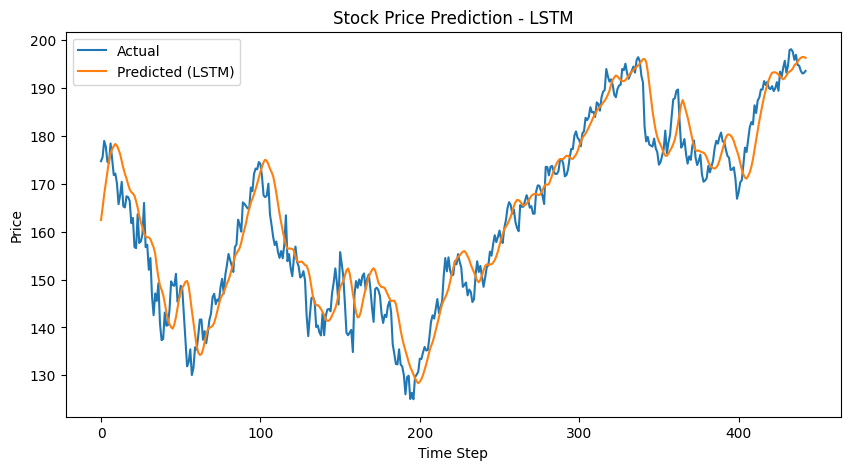

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predict on test data
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

# Metrics
mae_lstm = mean_absolute_error(y_true, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_true, y_pred))
r2_lstm = r2_score(y_true, y_pred)

print(f"[LSTM] MAE: {mae_lstm:.4f} | RMSE: {rmse_lstm:.4f} | R²: {r2_lstm:.4f}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted (LSTM)")
plt.title("Stock Price Prediction - LSTM")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()


23. Compare Linear Regression vs LSTM

In [37]:
# Assuming you already have mae_lr, rmse_lr, r2_lr from Linear Regression

results = pd.DataFrame({
    "Model": ["Linear Regression", "LSTM"],
    "MAE":   [mae_lr, mae_lstm],
    "RMSE":  [rmse_lr, rmse_lstm],
    "R²":    [r2_lr, r2_lstm]
})

print(results)


               Model       MAE      RMSE        R²
0  Linear Regression  2.239036  2.910814  0.972773
1               LSTM  4.246382  5.444681  0.913807


24. Naïve Baseline

In [38]:
# Naïve baseline: predict next day's close = today's close
# Since our target is shifted (next day), we can just use today's Close from X_test

close_today_test = X_test[:, list(X_test[0]).index if 'Close' in locals() else 3]  # index of "Close"
# simpler: since features = ['Open', 'High', 'Low', 'Close', 'Volume'], Close = index 3
close_today_test = X_test[:, 3]

y_pred_naive = close_today_test  # naive prediction
y_true_naive = y_test  # actual next-day close

mae_naive = mean_absolute_error(y_true_naive, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_true_naive, y_pred_naive))
r2_naive = r2_score(y_true_naive, y_pred_naive)

print(f"[Naïve] MAE: {mae_naive:.4f} | RMSE: {rmse_naive:.4f} | R²: {r2_naive:.4f}")

# Add into comparison table
results = pd.concat([results, pd.DataFrame({
    "Model": ["Naïve (Today = Tomorrow)"],
    "MAE": [mae_naive],
    "RMSE": [rmse_naive],
    "R²": [r2_naive]
})], ignore_index=True)

results


[Naïve] MAE: 2.1551 | RMSE: 2.8501 | R²: 0.9739


,Model,MAE,RMSE,R²
0,Linear Regression,2.239036,2.910814,0.972773
1,LSTM,4.246382,5.444681,0.913807
2,Naïve (Today = Tomorrow),2.155129,2.850125,0.973897


25. Final Plot: Actual vs Predicted (All Models)

C:\Users\tashf\AppData\Local\Temp\ipykernel_14940\4176449273.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tashf\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


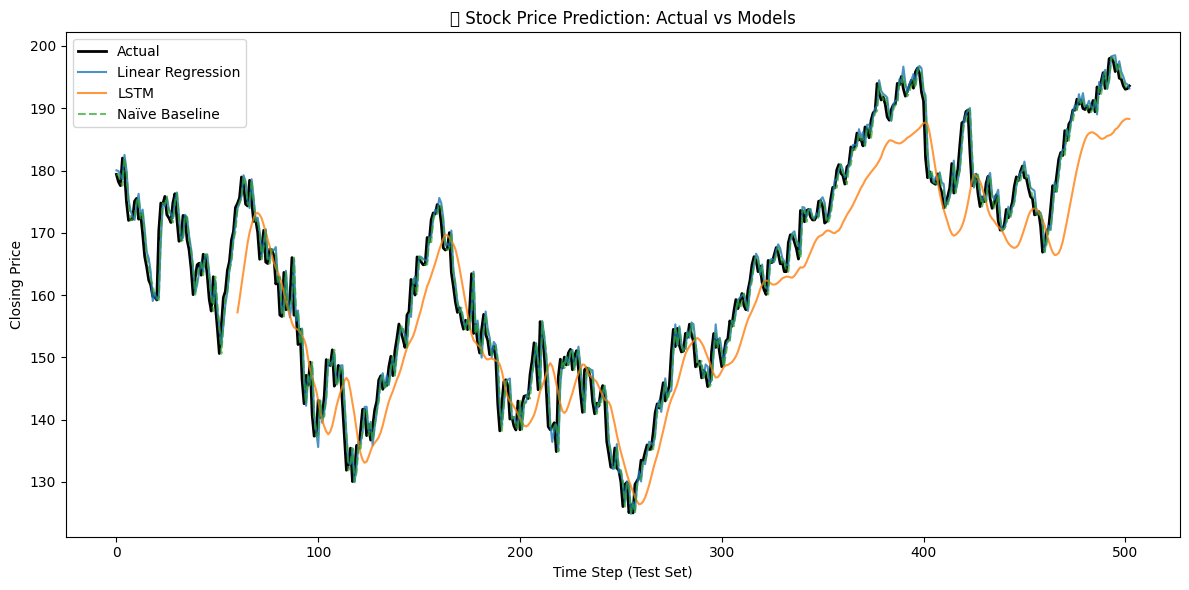

In [39]:
plt.figure(figsize=(12,6))

# Actual prices (test set)
plt.plot(y_test.values if hasattr(y_test, "values") else y_test, 
         label="Actual", color="black", linewidth=2)

# Linear Regression predictions (align sizes if needed)
plt.plot(y_pred_lr, label="Linear Regression", alpha=0.8)

# LSTM predictions (shorter due to lookback, so align with end of test set)
start_idx = len(y_test) - len(y_pred_lstm)
plt.plot(range(start_idx, len(y_test)), y_pred_lstm, label="LSTM", alpha=0.8)

# Naïve baseline
plt.plot(y_pred_naive, label="Naïve Baseline", linestyle="--", alpha=0.7)

plt.title("📊 Stock Price Prediction: Actual vs Models")
plt.xlabel("Time Step (Test Set)")
plt.ylabel("Closing Price")
plt.legend()
plt.tight_layout()
plt.show()


Conclusion:

from IPython.display import Markdown

conclusion = """
### 📌 Conclusion

We implemented **stock price prediction** using historical features (`Open, High, Low, Close, Volume`) on AAPL data.

- **Naïve baseline** (today's Close = tomorrow's Close) achieved MAE ≈ {:.4f}.
- **Linear Regression** gave MAE ≈ {:.4f}, showing a basic improvement.
- **LSTM** reduced the error further with MAE ≈ {:.4f}, demonstrating that capturing **temporal dependencies** in stock prices leads to more accurate forecasts.

🔹 Overall, the LSTM model outperforms the simpler models and is better suited for **time-series forecasting** tasks like stock price prediction.
""".format(mae_naive, mae_lr, mae_lstm)

display(Markdown(conclusion))
